In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import shap
import os
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings for cleaner output
np.random.seed(42)  # Set seed for consistent results
os.makedirs('outputs', exist_ok=True)  # Create outputs folder for visualizations

In [16]:
def load_data():
    # Get path to data folder
    base_dir = os.getcwd()
    file_path = os.path.join(base_dir, 'data', 'Churn_Modeling.csv')
    
    # Load dataset
    df = pd.read_csv(file_path)
    print("First few rows of the dataset:")
    print(df.head())
    return df

df = load_data()


First few rows of the dataset:
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  


In [17]:
def preprocess_data(df):
    # Drop irrelevant column
    df = df.drop(['customer_id'], axis=1)
    
    # Encode categorical variables
    le = LabelEncoder()
    df['gender'] = le.fit_transform(df['gender'])
    df = pd.get_dummies(df, columns=['country'], drop_first=True)
    
    # Define features and target
    X = df.drop('churn', axis=1)
    y = df['churn']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, df

X_train, X_test, y_train, y_test, df_processed = preprocess_data(df)

Performing Exploratory Data Analysis...
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None

Summary Statistics:
        customer_id  credit_score           age        tenure        balance  \
count  1.0

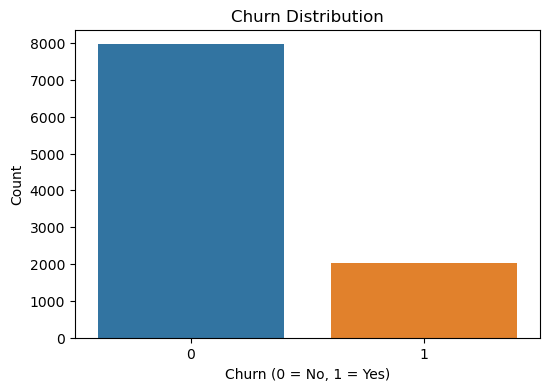

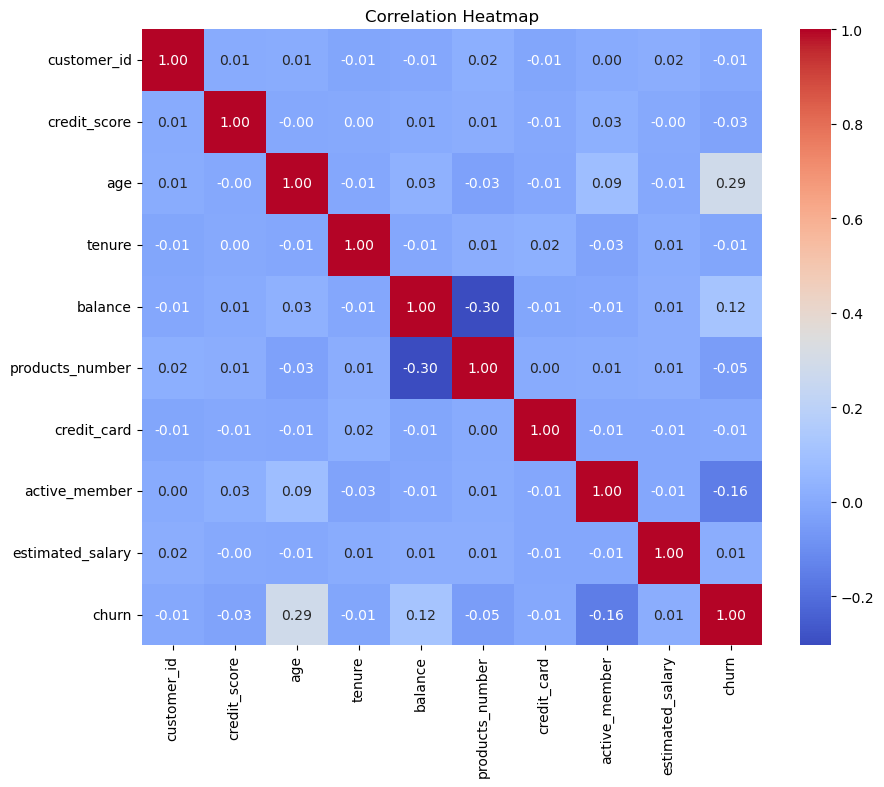

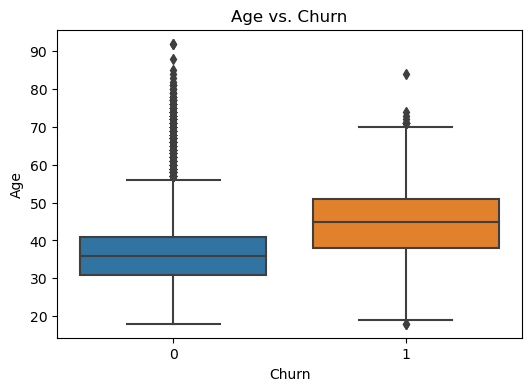

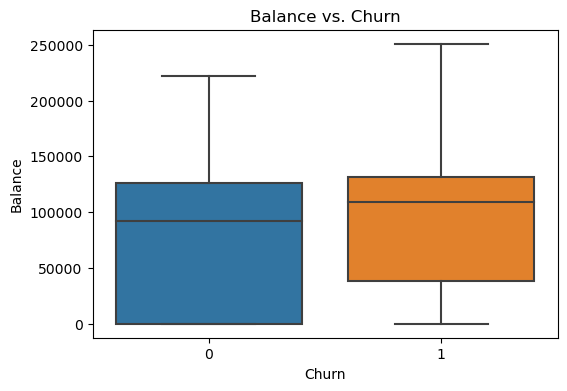

In [18]:
def perform_eda(df):
    # Check dataset info and summary
    print("Dataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    
    # Churn distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='churn', data=df)
    plt.title('Churn Distribution')
    plt.xlabel('Churn (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.savefig(os.path.join('outputs', 'churn_distribution.png'))
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.savefig(os.path.join('outputs', 'correlation_heatmap.png'))
    plt.show()
    
    # Age vs. Churn
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='churn', y='age', data=df)
    plt.title('Age vs. Churn')
    plt.xlabel('Churn')
    plt.ylabel('Age')
    plt.savefig(os.path.join('outputs', 'age_vs_churn.png'))
    plt.show()
    
    # Balance vs. Churn
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='churn', y='balance', data=df)
    plt.title('Balance vs. Churn')
    plt.xlabel('Churn')
    plt.ylabel('Balance')
    plt.savefig(os.path.join('outputs', 'balance_vs_churn.png'))
    plt.show()

print("Performing Exploratory Data Analysis...")
perform_eda(df)


Training and Evaluating Models...


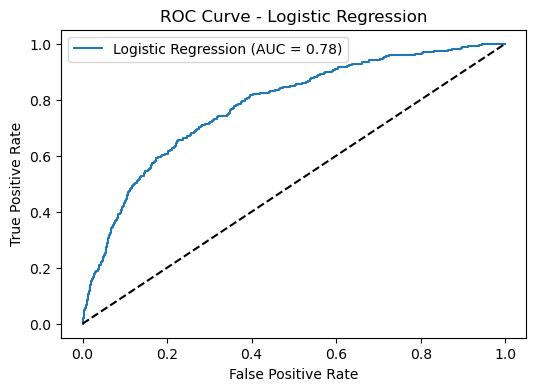

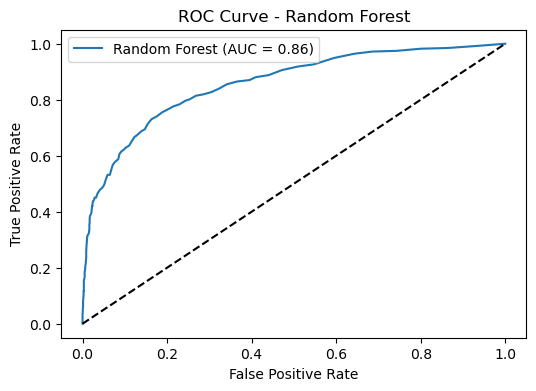

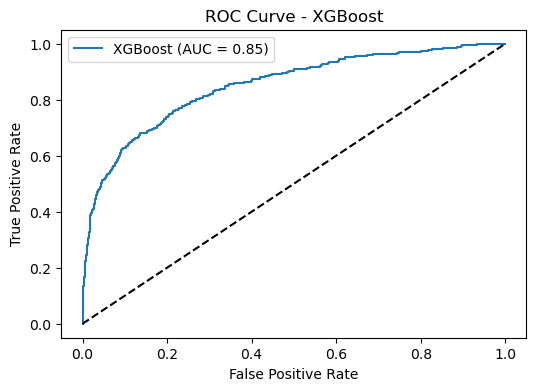

In [19]:
def train_models(X_train, X_test, y_train, y_test):
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    }
    
    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Evaluate
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba)
        }
        
        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["ROC AUC"]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.savefig(os.path.join('outputs', f'roc_curve_{name.lower().replace(" ", "_")}.png'))
        plt.show()
    
    return models, results

print("\nTraining and Evaluating Models...")
models, results = train_models(X_train, X_test, y_train, y_test)

In [20]:
print("\nModel Performance:")
results_df = pd.DataFrame(results).T
print(results_df)


Model Performance:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression    0.8110   0.552448  0.201018  0.294776  0.778867
Random Forest          0.8665   0.764706  0.463104  0.576862  0.857195
XGBoost                0.8640   0.713781  0.513995  0.597633  0.849537



Explaining XGBoost Model with SHAP...


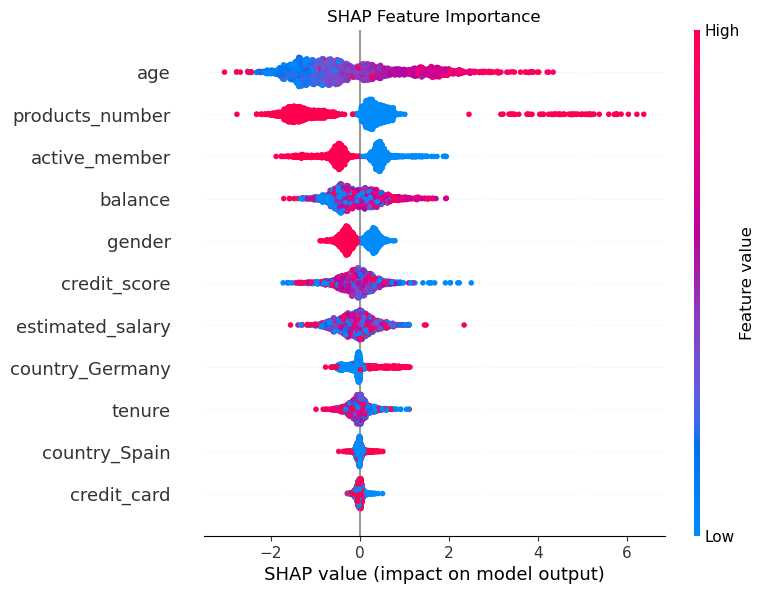

<Figure size 1000x600 with 0 Axes>

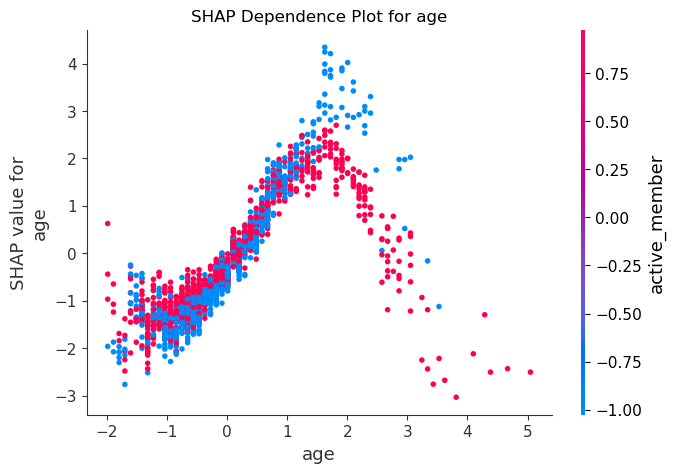

In [21]:
def explain_model(model, X_train, X_test, feature_names):
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model) if isinstance(model, (RandomForestClassifier, XGBClassifier)) else shap.LinearExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title('SHAP Feature Importance')
    plt.savefig(os.path.join('outputs', 'shap_summary.png'))
    plt.show()
    
    # Dependence plot for top feature
    top_feature_idx = np.abs(shap_values).mean(0).argmax()
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(top_feature_idx, shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(f'SHAP Dependence Plot for {feature_names[top_feature_idx]}')
    plt.savefig(os.path.join('outputs', f'shap_dependence_{feature_names[top_feature_idx]}.png'))
    plt.show()

print("\nExplaining XGBoost Model with SHAP...")
feature_names = df_processed.drop('churn', axis=1).columns
explain_model(models['XGBoost'], X_train, X_test, feature_names)

In [35]:
with open('visualizations.html', 'w') as f:
    f.write('''<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Bank Customer Churn Prediction Visualizations</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 40px;
            line-height: 1.6;
            background-color: #f4f4f4;
        }
        h1, h2 {
            color: #333;
            text-align: center;
        }
        .container {
            max-width: 1000px;
            margin: auto;
            padding: 20px;
            background: white;
            border-radius: 8px;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }
        .plot {
            margin: 20px 0;
            text-align: center;
        }
        .plot img {
            max-width: 100%;
            height: auto;
            border: 1px solid #ddd;
            border-radius: 4px;
        }
        .plot p {
            font-size: 16px;
            color: #555;
            margin-top: 10px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Bank Customer Churn Prediction Visualizations</h1>
        <p>This page shows the key visualizations from my churn prediction project. I analyzed a bank dataset to predict which customers might leave, using data analysis and machine learning. These plots are easy to understand and show my findings.</p>

        <h2>Exploratory Data Analysis</h2>
        <div class="plot">
            <img src="outputs/churn_distribution.png" alt="Churn Distribution">
            <p><strong>Churn Distribution</strong>: This shows how many customers stayed (0) vs. left (1). Most customers stay, but about 20% churn, so the data is imbalanced.</p>
        </div>
        <div class="plot">
            <img src="outputs/correlation_heatmap.png" alt="Correlation Heatmap">
            <p><strong>Correlation Heatmap</strong>: This shows how features like age and balance relate to each other and churn. Strong correlations (red or blue) help identify important factors.</p>
        </div>
        <div class="plot">
            <img src="outputs/age_vs_churn.png" alt="Age vs. Churn">
            <p><strong>Age vs. Churn</strong>: This box plot compares the age of customers who stayed vs. left. Older customers seem more likely to churn.</p>
        </div>
        <div class="plot">
            <img src="outputs/balance_vs_churn.png" alt="Balance vs. Churn">
            <p><strong>Balance vs. Churn</strong>: This shows how account balance relates to churn. Customers with higher balances may have different churn patterns.</p>
        </div>

        <h2>Model Performance</h2>
        <div class="plot">
            <img src="outputs/roc_curve_logistic_regression.png" alt="ROC Curve Logistic Regression">
            <p><strong>ROC Curve - Logistic Regression</strong>: This shows how well Logistic Regression predicts churn. The AUC score indicates its performance (higher is better).</p>
        </div>
        <div class="plot">
            <img src="outputs/roc_curve_random_forest.png" alt="ROC Curve Random Forest">
            <p><strong>ROC Curve - Random Forest</strong>: This plots the Random Forest models performance. It usually does better than Logistic Regression.</p>
        </div>
        <div class="plot">
            <img src="outputs/roc_curve_xgboost.png" alt="ROC Curve XGBoost">
            <p><strong>ROC Curve - XGBoost</strong>: This shows XGBoosts performance, which is often the best due to its ability to handle complex patterns.</p>
        </div>

        <h2>Explainable AI (SHAP)</h2>
        <div class="plot">
            <img src="outputs/shap_summary.png" alt="SHAP Summary">
            <p><strong>SHAP Feature Importance</strong>: This plot shows which features (like age or products_number) most influence churn predictions. Red means higher values increase churn risk.</p>
        </div>
        <div class="plot">
            <img src="outputs/shap_dependence_age.png" alt="SHAP Dependence Plot">
            <p><strong>SHAP Dependence Plot</strong>: This shows how the top feature (e.g., age) affects churn predictions. It helps explain why certain customers are at risk.</p>
        </div>
    </div>
</body>
</html>
''')